# SimCLR Contrastive Training Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [35]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf

In [79]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [24]:
# Library scripts
import raw_data_processing
import data_pre_processing
import simclr_models
import simclr_utitlities
import transformations

In [10]:
working_directory = 'test_run/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.mkdir(working_directory)


## MotionSense Dataset

In this section, the MotionSense dataset will be downloaded and parsed. The results will then be saved in a python pickle file.
(Note: This section only needs to be run once)

### Downloading & Unzipping

In [5]:
import requests
import zipfile

In [11]:
dataset_url = 'https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip?raw=true'

r = requests.get(dataset_url, allow_redirects=True)
with open(working_directory + 'B_Accelerometer_data.zip', 'wb') as f:
    f.write(r.content)

In [12]:

with zipfile.ZipFile(working_directory + 'B_Accelerometer_data.zip', 'r') as zip_ref:
    zip_ref.extractall(working_directory)

### Data Processing

In [13]:
accelerometer_data_folder_path = working_directory + 'B_Accelerometer_data/'
user_datasets = raw_data_processing.process_motion_sense_accelerometer_files(accelerometer_data_folder_path)

test_run/B_Accelerometer_data/dws_1
test_run/B_Accelerometer_data/dws_11
test_run/B_Accelerometer_data/dws_2
test_run/B_Accelerometer_data/jog_16
test_run/B_Accelerometer_data/jog_9
test_run/B_Accelerometer_data/sit_13
test_run/B_Accelerometer_data/sit_5
test_run/B_Accelerometer_data/std_14
test_run/B_Accelerometer_data/std_6
test_run/B_Accelerometer_data/ups_12
test_run/B_Accelerometer_data/ups_3
test_run/B_Accelerometer_data/ups_4
test_run/B_Accelerometer_data/wlk_15
test_run/B_Accelerometer_data/wlk_7
test_run/B_Accelerometer_data/wlk_8


In [14]:
with open(working_directory + 'motion_sense_user_split.pkl', 'wb') as f:
    pickle.dump({
        'user_split': user_datasets,
    }, f)

## Pre-processing

In [16]:
# Parameters
window_size = 400
input_shape = (window_size, 3)

# Dataset Metadata 
transformation_multiple = 1
dataset_name = 'motion_sense.pkl'
dataset_name_user_split = 'motion_sense_user_split.pkl'

label_list = ['null', 'sit', 'std', 'wlk', 'ups', 'dws', 'jog']
label_list_full_name = ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
has_null_class = True

label_map = dict([(l, i) for i, l in enumerate(label_list)])

output_shape = len(label_list)

model_save_name = f"motionsense_acc"

sampling_rate = 50.0
unit_conversion = scipy.constants.g

# a fixed user-split
test_users_fixed = [1, 14, 19, 23, 6]
def get_fixed_split_users(har_users):
    # test_users = har_users[0::5]
    test_users = test_users_fixed
    train_users = [u for u in har_users if u not in test_users]
    return (train_users, test_users)

In [17]:
with open(dataset_save_path + dataset_name_user_split, 'rb') as f:
    dataset_dict = pickle.load(f)
    user_datasets = dataset_dict['user_split']


In [18]:
har_users = list(user_datasets.keys())
train_users, test_users = get_fixed_split_users(har_users)
print(f'Testing: {test_users}, Training: {train_users}')

Testing: [1, 14, 19, 23, 6], Training: [10, 11, 12, 13, 15, 16, 17, 18, 2, 20, 21, 22, 24, 3, 4, 5, 7, 8, 9]


In [19]:
np_train, np_val, np_test = data_pre_processing.pre_process_dataset_composite(
    user_datasets=user_datasets, 
    label_map=label_map, 
    output_shape=output_shape, 
    train_users=train_users, 
    test_users=test_users, 
    window_size=window_size, 
    shift=window_size//2, 
    normalise_dataset=True, 
    verbose=1
)



Test
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([112, 133, 360, 335, 148, 331]))
(array([1, 2, 3, 4, 5, 6]), array([360, 335, 331, 148, 112, 133]))
-----------------
Train
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([ 449,  480, 1282, 1146,  546, 1308]))
(array([1, 2, 3, 4, 5, 6]), array([1282, 1146, 1308,  546,  449,  480]))
-----------------
(4168, 400, 3)
(1043, 400, 3)
(1419, 400, 3)


## SimCLR Training

In [22]:
batch_size = 512
decay_steps = 1000
epochs = 200
temperature = 0.1
trasnformation_indices = [1, 2] # Use Scaling and rotation trasnformation

trasnform_funcs_vectorized = [
    transformations.noise_transform_vectorized, 
    transformations.scaling_transform_vectorized, 
    transformations.rotation_transform_vectorized, 
    transformations.negate_transform_vectorized, 
    transformations.time_flip_transform_vectorized, 
    transformations.time_segment_permutation_transform_improved, 
    transformations.time_warp_transform_low_cost, 
    transformations.channel_shuffle_transform_vectorized
]
transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']



In [25]:
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
tf.keras.backend.set_floatx('float32')

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
transformation_function = simclr_utitlities.generate_combined_transform_function(trasnform_funcs_vectorized, indices=trasnformation_indices)

base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(simclr_model, np_train[0], optimizer, batch_size, transformation_function, temperature=temperature, epochs=epochs, is_trasnform_function_vectorized=True, verbose=1)

simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)



<function scaling_transform_vectorized at 0x7f8b8c07d9e0>
<function rotation_transform_vectorized at 0x7f8b8c07da70>
Model: "base_model_simclr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 400, 3)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 377, 32)           2336      
_________________________________________________________________
dropout_6 (Dropout)          (None, 377, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 362, 64)           32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 362, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 355, 96)           49248    

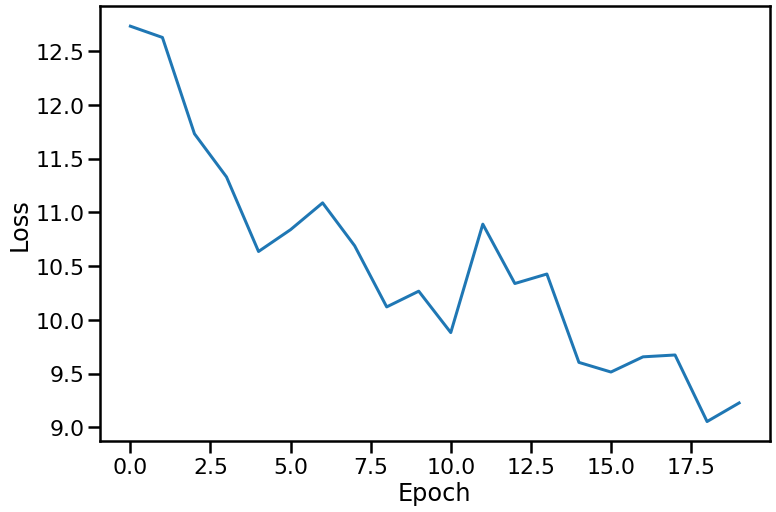

In [38]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Fine-tuning and Evaluation

### Linear Model

In [39]:

total_epochs = 50
batch_size = 200
tag = "linear_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(linear_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = linear_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Train on 4168 samples, validate on 1043 samples
Epoch 1/50
4168/4168 [==============================] - 4s 984us/sample - loss: 1.4397 - categorical_accuracy: 0.4712 - auc: 0.8225 - precision: 0.8283 - recall: 0.1991 - val_loss: 1.3094 - val_categorical_accuracy: 0.5436 - val_auc: 0.8917 - val_precision: 0.7845 - val_recall: 0.2234
Epoch 2/50
4168/4168 [==============================] - 3s 649us/sample - loss: 1.1994 - categorical_accuracy: 0.6178 - auc: 0.9051 - precision: 0.8509 - recall: 0.3616 - val_loss: 1.1900 - val_categorical_accuracy: 0.6798 - val_auc: 0.9215 - val_precision: 0.8871 - val_recall: 0.3164
Epoch 3/50
4168/4168 [==============================] - 2s 572us/sample - loss: 1.1009 - categorical_accuracy: 0.7054 - auc: 0.9291 - precision: 0.8633 - recall: 0.4014 - val_loss: 1.1173 - val_categorical_accuracy: 0.7114 - val_auc: 0.9320 - val_precision: 0.9048 - val_recall: 0.3643
Epoch 4/50
4168/4168 [==============================] - 2s 567us/sample - loss: 1.0296 - categ

### Full HAR Model

In [40]:

total_epochs = 50
batch_size = 200
tag = "full_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
full_evaluation_model = simclr_models.create_full_classification_model_from_base_model(simclr_model, output_shape, model_name="TPN", intermediate_layer=7, last_freeze_layer=4)

full_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(full_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = full_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

full_eval_best_model = tf.keras.models.load_model(full_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(full_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(full_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Train on 4168 samples, validate on 1043 samples
Epoch 1/50
4168/4168 [==============================] - 6s 1ms/sample - loss: 1.0101 - categorical_accuracy: 0.6742 - auc: 0.9224 - precision: 0.8835 - recall: 0.4422 - val_loss: 0.6862 - val_categorical_accuracy: 0.8082 - val_auc: 0.9699 - val_precision: 0.9291 - val_recall: 0.5906
Epoch 2/50
4168/4168 [==============================] - 5s 1ms/sample - loss: 0.4131 - categorical_accuracy: 0.8673 - auc: 0.9889 - precision: 0.9464 - recall: 0.7838 - val_loss: 0.4159 - val_categorical_accuracy: 0.8917 - val_auc: 0.9844 - val_precision: 0.9396 - val_recall: 0.8198
Epoch 3/50
4168/4168 [==============================] - 4s 1ms/sample - loss: 0.2521 - categorical_accuracy: 0.9271 - auc: 0.9961 - precision: 0.9569 - recall: 0.8896 - val_loss: 0.2704 - val_categorical_accuracy: 0.9195 - val_auc: 0.9936 - val_precision: 0.9464 - val_recall: 0.8802
Epoch 4/50
4168/4168 [==============================] - 5s 1ms/sample - loss: 0.1718 - categorical_a

## t-SNE Plots

### Parameters

In [73]:
# Select a model from which the intermediate representations are extracted
target_model = simclr_model 
perplexity = 30.0


### t-SNE Representations

In [92]:
intermediate_model = simclr_models.extract_intermediate_model_from_base_model(target_model, intermediate_layer=7)
intermediate_model.summary()

embeddings = intermediate_model.predict(np_test[0], batch_size=600)
tsne_model = sklearn.manifold.TSNE(perplexity=perplexity, verbose=1, random_state=42)
tsne_projections = tsne_model.fit_transform(embeddings)



Model: "base_model_simclr_layer_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 400, 3)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 377, 32)           2336      
_________________________________________________________________
dropout_6 (Dropout)          (None, 377, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 362, 64)           32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 362, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 355, 96)           49248     
_________________________________________________________________
dropout_8 (Dropout)          (None, 355, 

### Plotting

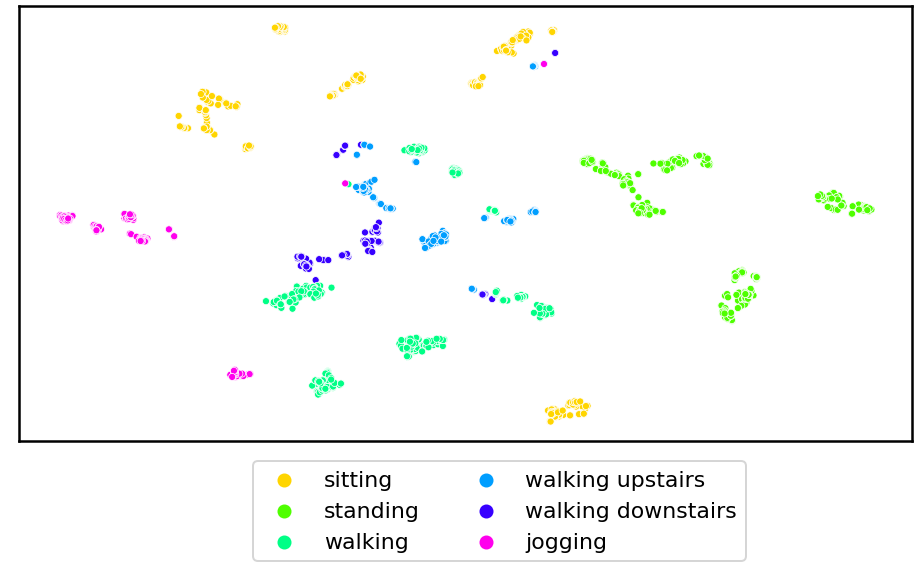

In [93]:
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(16,8))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=sns.color_palette("hsv", len(unique_labels)),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label]) 

### Custom Color maps (Optional)

This section can be run to produce plots where semantically similar classes share similar colors. This requires the definition of a custom mapping of classes to colors.

In [94]:
# This is used to select colors for labels which are close to each other
# Each pair corresponds to one label class
# i.e. ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
# The first number determines the color map, and the second determines its value along the color map
# So 'sitting', 'standing' will share similar colors, and 'walking', 'walking upstairs', 'walking downstairs' will share another set of similar colors
label_color_spectrum = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0)] 

# This step generates a list of colors for different categories of activities
# Here we assume 5 categories, and 5 different intesities within each category
major_colors = ['cool', 'Blues', 'Greens', 'Oranges', 'Purples']
color_map_base = dict (
    [((i, j), color) for i, major_color in enumerate(major_colors) for j, color in enumerate(reversed(sns.color_palette(major_color, 5))) ]
)
color_palette = np.array([color_map_base[color_index] for color_index in label_color_spectrum])

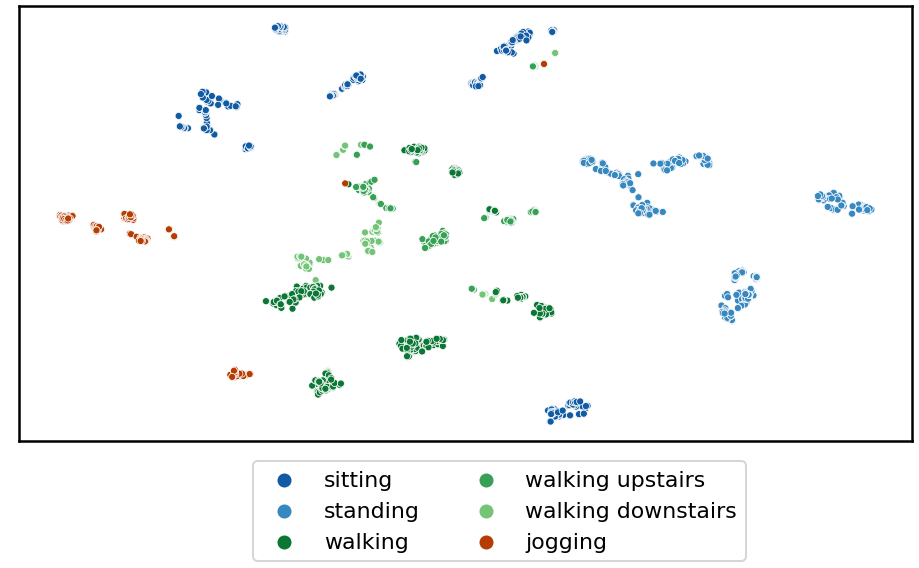

In [95]:
# This selects the appropriate number of colors to be used in the plot
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(16,8))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=list(color_palette[unique_labels]),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label]) 
